In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

# Preprocessing

In [187]:
covid_data = pd.read_excel("/Users/mikaelw/Documents/LOISIRS/Programmation/Python/Machine_learning/datasets/dataset_covid.xlsx")

In [188]:
covid_data

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
#Elimination of columns that have more than 91% of nan values
covid_data = covid_data[covid_data.columns[covid_data.isna().sum()/len(covid_data) < 0.90]]

# Elimination of Patient Id column, 3 columns Patient addmited to ... 
covid_data = covid_data.drop(["Patient ID", "Patient addmited to regular ward (1=yes, 0=no)",
                             "Patient addmited to semi-intensive unit (1=yes, 0=no)",
                             "Patient addmited to intensive care unit (1=yes, 0=no)",
                              "Influenza B, rapid test","Influenza A, rapid test"], axis=1) 
# If Influenza rapid test is keep, a lot of nan values "added", already columns for infuenza tests
covid_data.columns

Index(['Patient age quantile', 'SARS-Cov-2 exam result', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ', 'Red blood Cells',
       'Lymphocytes', 'Mean corpuscular hemoglobin concentration (MCHC)',
       'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)',
       'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2'],
      dtype='object')

In [190]:
train_set, test_set = train_test_split(covid_data, test_size=0.20, random_state=0)

In [191]:
train_set["SARS-Cov-2 exam result"].value_counts()  # proportion similar than before train_test_split

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [192]:
# Encoding
def encode(df): 
    encoder = {"not_detected": 0, "negative": 0, "detected": 1, "positive": 1}
    for var in df.select_dtypes("object"):
        df.loc[:,var] = df.loc[:,var].replace(encoder)
    return df

In [193]:
# Treatement of Missing values
def treat_miss_values(df):
    df = df.dropna(axis=0)
    return df

In [194]:
def preprocessing(df):
    df = encode(df)
    df = treat_miss_values(df)
    X = df.drop("SARS-Cov-2 exam result", axis = 1)
    y = df["SARS-Cov-2 exam result"]
    return X, y

In [195]:
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)
y_test.value_counts()
X_train.columns

/Users/mikaelw/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Index(['Patient age quantile', 'Hematocrit', 'Hemoglobin', 'Platelets',
       'Mean platelet volume ', 'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)',
       'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2'],
      dtype='object')

In [196]:
model_a = RandomForestClassifier(random_state=0)
# Use of a model to test the preprocessing stage. SVC used because efficient with small datasets 
model_b = make_pipeline(StandardScaler(), SVC(random_state=0))
# note : Despite the dataset is already standardised, it is needed to normalize it after the train test split, because the mean and std have changed  

In [197]:
def evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_pred, y_test))
    train_sizes_abs, train_scores, test_scores= learning_curve(model, X_train, y_train,
                                                               train_sizes=np.linspace(0.2, 1, 10),
                                                              cv=5, scoring ="f1")
    plt.figure()
    plt.plot(train_sizes_abs,train_scores.mean(axis=1), label="train score (f1)")
    plt.plot(train_sizes_abs, test_scores.mean(axis=1), label="test score (f1)")
    plt.legend()

              precision    recall  f1-score   support

           0       1.00      0.83      0.91        65
           1       0.08      1.00      0.15         1

    accuracy                           0.83        66
   macro avg       0.54      0.92      0.53        66
weighted avg       0.99      0.83      0.90        66



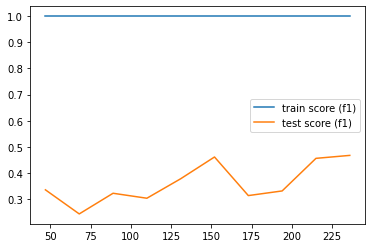

In [198]:
evaluation(model_a, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        60
           1       0.42      0.83      0.56         6

    accuracy                           0.88        66
   macro avg       0.70      0.86      0.74        66
weighted avg       0.93      0.88      0.90        66



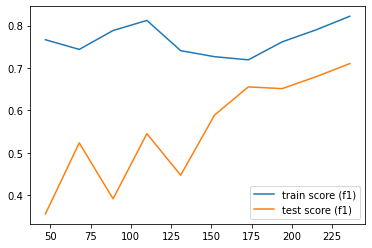

In [199]:
evaluation(model_b, X_train, X_test, y_train, y_test)

# Trying Feature selection with RFE

In [200]:
important_columns = ["SARS-Cov-2 exam result", "Patient age quantile"]

In [201]:
selector = RFE(SGDClassifier(random_state=0), n_features_to_select=8)  #Tried with differents n_features_to_select
selector.fit(X_train, y_train) 
columns_to_keep = list(X_train.columns[selector.get_support()])
covid_data_RFEselection = covid_data[columns_to_keep + important_columns]
covid_data_RFEselection.columns

Index(['Leukocytes', 'Eosinophils', 'Influenza B', 'CoronavirusNL63',
       'Rhinovirus/Enterovirus', 'CoronavirusOC43', 'Inf A H1N1 2009',
       'Metapneumovirus', 'SARS-Cov-2 exam result', 'Patient age quantile'],
      dtype='object')

In [202]:
# Preprocessing after the RFE feature selection
train_set_RFEs, test_set_RFEs = train_test_split(covid_data_RFEselection, test_size=0.20, random_state=0)
X_train_RFEs, y_train_RFEs = preprocessing(train_set_RFEs)
X_test_RFEs, y_test_RFEs = preprocessing(test_set_RFEs)

/Users/mikaelw/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


              precision    recall  f1-score   support

           0       0.91      0.86      0.88        57
           1       0.33      0.44      0.38         9

    accuracy                           0.80        66
   macro avg       0.62      0.65      0.63        66
weighted avg       0.83      0.80      0.81        66



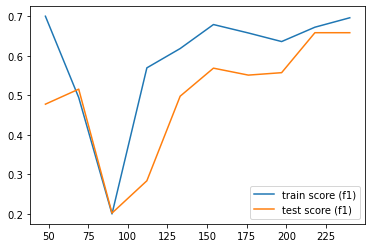

In [203]:
evaluation(model_b, X_train_RFEs, X_test_RFEs, y_train_RFEs, y_test_RFEs) # Scores are lower than before = > Not use RFE

# Trying Manual feature selection

In [204]:
blood_var = list(covid_data.select_dtypes('float'))
blood_data = covid_data[blood_var + important_columns]

In [205]:
# Preprocessing after the manual feature selection
train_set_BLOODs, test_set_BLOODs = train_test_split(blood_data, test_size=0.20, random_state=0)
X_train_BLOODs, y_train_BLOODs = preprocessing(train_set_BLOODs)
X_test_BLOODs, y_test_BLOODs = preprocessing(test_set_BLOODs)

/Users/mikaelw/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


              precision    recall  f1-score   support

           0       1.00      0.88      0.94       108
           1       0.19      1.00      0.32         3

    accuracy                           0.88       111
   macro avg       0.59      0.94      0.63       111
weighted avg       0.98      0.88      0.92       111



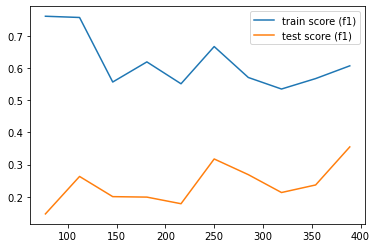

In [206]:
evaluation(model_b, X_train_BLOODs, X_test_BLOODs, y_train_BLOODs, y_test_BLOODs) # Recall higher than before but f1 Score lower than before 
# = > We want a higher f1 score so we will choose to not use manual selection